In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from scipy import ndimage

In [2]:
class Corner_detector(object):
    def __init__(self, k, img, sigma, threshold_ratio, suppression_radius, response_window_size, gaussian_kernel_size):
        self.k = k
        self.img = img
        self.sigma = sigma
        self.threshold_ratio = threshold_ratio
        self.suppression_radius = suppression_radius
        self.response_window_size = response_window_size
        self.gaussian_kernel_size = gaussian_kernel_size

    def to_gray_scale(self):
        self.img = np.dot(self.img[..., :3], [0.2989, 0.5870, 0.1140])

    def show_plot(self):
        plt.imshow(self.img, cmap = plt.get_cmap('gray'))

    def spatial_derivative(self):
        blur_img = ndimage.gaussian_filter(self.img, self.sigma)

        Ix = ndimage.convolve(blur_img, np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]))
        Iy = ndimage.convolve(blur_img, np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]))

        Ix = Ix/np.max(Ix)
        Iy = Iy/np.max(Iy)
        return Ix, Iy

    def response_calculate(self, Ix, Iy):
        response = np.zeros(self.img.shape)

        Ix_2 = Ix ** 2
        Iy_2 = Iy ** 2

        IxIy = Ix * Iy
        IyIx = Iy * Ix

        offset = int(self.response_window_size / 2)

        for y in range (offset, self.img.shape[0] - offset):
            for x in range (offset, self.img.shape[1] - offset):
                w_Ix_2 = Ix_2[y - offset : y + offset + 1, x - offset : x + offset + 1]
                w_Iy_2 = Iy_2[y - offset : y + offset + 1, x - offset : x + offset + 1]

                w_IxIy = IxIy[y - offset : y + offset + 1, x - offset : x + offset + 1]
                # w_IyIx = IyIx[y - offset : y + offset + 1, x - offset : x + offset + 1]

                det = (w_Ix_2.sum() * w_Iy_2.sum()) - (w_IxIy.sum() ** 2)

                trace = w_Ix_2.sum() + w_Iy_2.sum()

                r = det - self.k * (trace ** 2)

                response[y][x] = r

        return response/np.max(response)

    def non_maximum_suppression(self, response):
        threshold = np.max(response) * self.threshold_ratio
        offset = int(self.suppression_radius / 2)

        for y in range (offset, response.shape[0] - offset):
            for x in range (offset, response.shape[1] - offset):   
                window = response[y - offset : y + offset + 1, x - offset : x + offset + 1]
                max_corner = np.max(window)

                if (max_corner > threshold):
                    for i in range(y - offset, y + offset + 1):
                        for j in range (x - offset, x + offset + 1):
                            if (response[i][j] != max_corner):
                                response[i][j] = 0
                else:
                    response[y][x] = 0

        corner_x_list = []
        corner_y_list = []
        for y in range(response.shape[0]):
            for x in range(response.shape[1]):
                if (response[y][x] > threshold):
                    corner_x_list.append(x)
                    corner_y_list.append(y)

        return response, corner_x_list, corner_y_list

In [3]:
image = imageio.imread('image1.jfif')

In [4]:
agent = Corner_detector(
    k = 0.05,
    sigma = 1,
    img = image, 
    gaussian_kernel_size = 5, 
    response_window_size = 10, 
    threshold_ratio = 0.01,
    suppression_radius = 10)

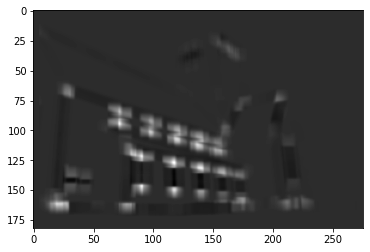

In [5]:
agent.to_gray_scale()
Ix, Iy = agent.spatial_derivative()
response = agent.response_calculate(Ix, Iy)
plt.imshow(response, cmap = plt.get_cmap('gray'))

In [6]:
_, corner_x_list, corner_y_list = agent.non_maximum_suppression(response)

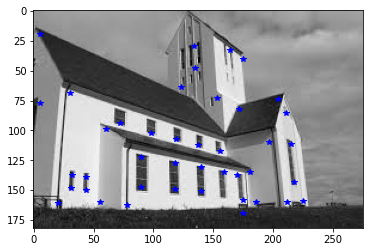

In [7]:
plt.plot(corner_x_list,corner_y_list, "b*")
plt.imshow(image, cmap = plt.get_cmap('gray'))